In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import os, math, time, random
from pathlib import Path
import torch
from torch import optim
import matplotlib.pyplot as plt
import numpy as np

# Import high-level experiment functions
from src.experiment_runner import (
    setup_experiment, load_datasets, create_models, 
    train_task_0, compute_fisher_information, 
    train_continual_learning_tasks, analyze_fisher_errors_across_timesteps,
    evaluate_fid, sample_and_visualize
)
from src.parameter_scoring import compute_param_scores
from src.ewc import EWC
from src.fisher_analysis import empirical_fisher_dense, optimal_rank1_coeff
from src.experimental_utils import analyze_fisher_approximations
import src.utils as utils
from src.gr import GenerativeReplay

In [3]:
# Setup experiment with one function call
device, ROOT = setup_experiment(seed=123)

Device: cuda
Experiment root directory: ddim_unit_tests


In [4]:
# Load all datasets with one function call
datasets = load_datasets(batch_size=128)
cl_mnist_train_loaders, cl_mnist_test_loaders = datasets['cl_mnist_train'], datasets['cl_mnist_test']
cl_cifar_train_loaders, cl_cifar_test_loaders = datasets['cl_cifar_train'], datasets['cl_cifar_test']

Building DataLoaders for each class in train dataset...


100%|██████████| 50000/50000 [00:07<00:00, 6482.37it/s]


Building DataLoaders for each class in MNIST test dataset...


100%|██████████| 10000/10000 [00:01<00:00, 5834.72it/s]


Building DataLoaders for each class in train dataset...


100%|██████████| 60000/60000 [00:09<00:00, 6571.64it/s]


Building DataLoaders for each class in MNIST test dataset...


100%|██████████| 10000/10000 [00:01<00:00, 6759.68it/s]


In [5]:
# Create models and optimizers with one function call
mnist_model, cifar_model, mnist_opt, cifar_opt = create_models(device)

MNIST model parameters: 35743745
CIFAR model parameters: 35747331


In [ ]:
# Train Task 0 with one function call
train_task_0(mnist_model, cl_mnist_train_loaders[0], mnist_opt, 200, ROOT, device, "mnist_model_large")

In [7]:
# load the model
cifar_model.load_state_dict(torch.load( ROOT / "cifar_model.pth", map_location=device))
mnist_model.load_state_dict(torch.load( ROOT / "mnist_model_large.pth", map_location=device))

<All keys matched successfully>

In [ ]:
# Using the modular compute_param_scores function
param_scores = compute_param_scores(
    mnist_model, 
    t_level=0, 
    loaders_by_class=cl_mnist_train_loaders, 
    device=device, 
    target_class=0, 
    max_samples=None
)
print(f"Parameter scores shape: {param_scores.shape}")

In [8]:
# Compute Fisher information with one function call  
c, mu, diag = compute_fisher_information(mnist_model, cl_mnist_train_loaders, device)
# save the fisher information
torch.save((c, mu, diag), ROOT / "mnisy-fisher_info_task0.pth")

Computing Fisher information...


[pass2] c* @ t=0: 100%|██████████| 99/99 [08:37<00:00,  5.23s/it]


Streaming optimal coefficient c*: 2.8782996760523107


In [ ]:
# Using the modular EWC class


In [17]:
frozen = utils.freeze_model(mnist_model)

ewc_diag = EWC(frozen, "diag", diag=diag)
ewc_rank1_opt = EWC(frozen, "rank1_opt", mu=mu, c=c)
ewc_rank1 = EWC(frozen, "rank1", mu=mu, c=c)

print("EWC objects created successfully")
# print(f"EWC diagonal loss example: {ewc_diag.loss().item()}")
# print(f"EWC rank1_opt loss example: {ewc_rank1_opt.loss().item()}")
# print(f"EWC rank1 loss example: {ewc_rank1.loss().item()}")

gr = GenerativeReplay(frozen, [0,1], batch_size=128, seed=123, device=device)
print("Generative Replay object created successfully")

EWC objects created successfully


100%|██████████| 2/2 [04:33<00:00, 136.76s/it]

GenerativeReplay: built pool of 10000 images for replay.
Generative Replay object created successfully


In [18]:
optimizer = optim.Adam(mnist_model.parameters(), lr=2e-4)
utils.train_one_task(mnist_model, cl_mnist_train_loaders[1], 1, optimizer, 
                     ewc_diag, 
                     gr,
                     200, ROOT, device)


 63%|██████▎   | 126/200 [48:36<28:32, 23.14s/it] 


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Replayed samples shape: torch.Size([64, 1, 32, 32]), Replayed labels shape: torch.Size([64])
Replayed label distribution: {np.int64(0): np.int64(31), np.int64(1): np.int64(33)}


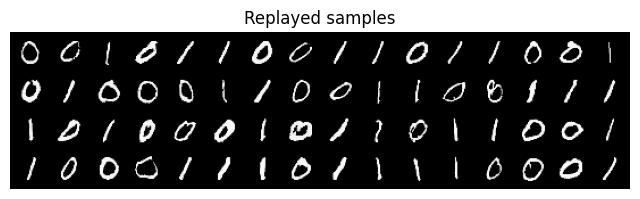

Replayed labels: [0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0
 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1]


In [13]:
x, y = gr.replay("uniform")

print(f"Replayed samples shape: {x.shape}, Replayed labels shape: {y.shape}")
# compute the distribution of the replayed labels
unique, counts = np.unique(y.cpu().numpy(), return_counts=True)
label_distribution = dict(zip(unique, counts))
print("Replayed label distribution:", label_distribution)

# display the replayed samples
plt.figure(figsize=(8,4))
plt.imshow(utils.make_grid(x.cpu(), nrow=16).permute(1,2,0))
plt.title("Replayed samples")
plt.axis('off')
plt.show()

# print labels
print("Replayed labels:", y.cpu().numpy())

In [ ]:
# Train Task 1 with different EWC variants using one-liner function calls
base_state = torch.load(ROOT / "mnist_model_large.pth", map_location=device)

# Uncomment any variant you want to train:
# mnist_model.load_state_dict(base_state); train_continual_learning_tasks(mnist_model, cl_mnist_train_loaders, optim.Adam(mnist_model.parameters(), lr=2e-4), "diag", c, mu, diag, 200, ROOT, device, "diag")
# mnist_model.load_state_dict(base_state); train_continual_learning_tasks(mnist_model, cl_mnist_train_loaders, optim.Adam(mnist_model.parameters(), lr=2e-4), "rank1_opt", c, mu, diag, 200, ROOT, device, "rank1_opt")
mnist_model.load_state_dict(base_state); train_continual_learning_tasks(mnist_model, cl_mnist_train_loaders, optim.Adam(mnist_model.parameters(), lr=2e-4), "rank1", c, mu, diag, 200, ROOT, device, "rank1")

In [ ]:
print("c*:", c.item())

In [ ]:
# Using the modular compare_fisher_errors_streaming function
out = compare_fisher_errors_streaming(
    mnist_model, 500, cl_mnist_train_loaders, mu, c, device=device, target_class=0, max_samples=None
)
print("Fisher error comparison results:")
print(out)

In [ ]:
# Using the modular empirical_fisher_dense function
Fisher = empirical_fisher_dense(param_scores).to('cpu')  # (D, D)
print(f"Fisher matrix shape: {Fisher.shape}")

In [ ]:
# Using the modular optimal_rank1_coeff function
c_batch, mu_batch = optimal_rank1_coeff(param_scores, eps=1e-12, use_float64=False)
print("Optimal coefficient c*:", c_batch.item())
print(f"Mu shape: {mu_batch.shape}")

In [ ]:
# Using the modular analyze_fisher_approximations function
analysis_results = analyze_fisher_approximations(param_scores, Fisher)
print("Fisher matrix analysis:")
print(f"Diagonal error: {analysis_results['diagonal_error']}")
print(f"Rank-1 error: {analysis_results['rank1_error']}")
print(f"Optimal rank-1 error: {analysis_results['rank1_optimal_error']}")
print(f"Optimal coefficient: {analysis_results['optimal_coefficient']}")

In [ ]:
# Analyze Fisher approximation errors across timesteps with one function call
error_analysis = analyze_fisher_errors_across_timesteps(mnist_model, cl_mnist_train_loaders, device, ROOT)

In [ ]:
# Print error analysis results
print("Diagonal Errors:", error_analysis['diag_errors'])
print("Rank-1 Errors:", error_analysis['rank1_errors'])
print("Optimal Rank-1 Errors:", error_analysis['rank1_optimal_errors'])

In [ ]:
# Plot error analysis with log scale
t_levels = error_analysis['t_levels']
plt.figure(figsize=(10, 5))
plt.plot(t_levels, np.array(error_analysis['diag_errors'])*10000, label='Diagonal Error', marker='o')
plt.plot(t_levels, np.array(error_analysis['rank1_errors'])*10000, label='Rank-1 Error', marker='o')
plt.plot(t_levels, np.array(error_analysis['rank1_optimal_errors'])*10000, label='Optimal Rank-1 Error', marker='o')
plt.yscale('log')
plt.xlabel('Timestep Level')
plt.ylabel('Error Norm')
plt.title('EWC Fisher Matrix Approximation Errors')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Using the modular functions to analyze Fisher matrix
Fisher = Fisher.to('cpu')
param_scores = param_scores.to('cpu')

# Use the modular optimal_rank1_coeff function 
c_analysis, mu_analysis = optimal_rank1_coeff(param_scores, eps=1e-12, use_float64=False)

# Diagonal approximation
F_diag = torch.diag(torch.diag(Fisher))
err_diag = torch.linalg.norm(Fisher - F_diag)

# Rank-1 approximation with optimal coefficient
F_r1_score = mu_analysis.unsqueeze(1) @ mu_analysis.unsqueeze(0) * c_analysis
err_r1_score = torch.linalg.norm(Fisher - F_r1_score)

print(f"‖F-F_diag‖_F = {err_diag:.10f},  ‖F-F_r1_score‖_F = {err_r1_score:.10f}")

In [ ]:
# Empty cell for future use
pass

# test FID

In [ ]:
# Evaluate FID with one function call
fid_cifar = evaluate_fid(cifar_model, cl_cifar_test_loaders[0], device)

In [ ]:
# Load model variant and evaluate FID with one function call
mnist_model.load_state_dict(torch.load(ROOT / "mnist_model_large-task1-rank1.pth", map_location=device))
fid_mnist = evaluate_fid(mnist_model, cl_mnist_test_loaders[0], device)

In [ ]:
# Generate and visualize samples with one function call
samples = sample_and_visualize(mnist_model, device, n_samples=16)

In [ ]:
# Check available test loaders
print("Available test loader keys:", cl_mnist_test_loaders.keys())